In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import glob
import datetime as dt
import time
import pprint
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Times New Roman'

#Data Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#modeling
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Data Loading

In [28]:
data = pd.concat(map(pd.read_csv,glob.glob('./Data'+'/*.csv')))
data.head(3)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Nairobi,2013-01-01,76.0,60.8,67.5,76.0,60.8,67.5,61.1,81.5,...,15.2,7,NaN,2013-01-01T06:30:31,2013-01-01T18:42:07,0.58,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"63739099999,HKJK,63741099999,HKNC,remote,HKNW,..."
1,Nairobi,2013-01-02,77.6,63.5,68.4,77.6,63.5,68.4,61.1,78.8,...,15.0,6,NaN,2013-01-02T06:31:00,2013-01-02T18:42:34,0.62,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"63739099999,HKJK,63741099999,HKNW,63740099999,..."
2,Nairobi,2013-01-03,73.4,61.5,67.3,73.4,61.5,67.3,57.1,71.5,...,20.7,8,NaN,2013-01-03T06:31:28,2013-01-03T18:43:01,0.67,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"63739099999,HKJK,63741099999,HKNC,HKNW,6374009..."


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 729
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3652 non-null   object 
 1   datetime          3652 non-null   object 
 2   tempmax           3652 non-null   float64
 3   tempmin           3652 non-null   float64
 4   temp              3652 non-null   float64
 5   feelslikemax      3652 non-null   float64
 6   feelslikemin      3652 non-null   float64
 7   feelslike         3652 non-null   float64
 8   dew               3652 non-null   float64
 9   humidity          3652 non-null   float64
 10  precip            3652 non-null   float64
 11  precipprob        3652 non-null   int64  
 12  precipcover       3652 non-null   float64
 13  preciptype        1329 non-null   object 
 14  snow              2186 non-null   float64
 15  snowdepth         2188 non-null   float64
 16  windgust          509 non-null    float64
 

## Attributes Selection

In [30]:
nbi_w_data = pd.DataFrame({
                           'date': data['datetime'],             # Date
                           'pressure': data['sealevelpressure'], # Atmospheric pressure
                           'cloud_cover': data['cloudcover'],    # Cloud cover
                           'humidity': data['humidity'],         # Humidity
                           'rainfall': data['precip'],           # Rainfall
                           'temperature': data['temp'],          #Temperature
                           'wind_direction': data['winddir'],    # Wind Direction
                           'wind_speed': data['windspeed'],      # Wind Speed
                           'wind_gust': data['windgust'],        # Wind Gust
                           'condition': data['icon'],            # Weather Condition
                           'solar_radiation': data['solarradiation'], # Solar Energy
                           'uvindex': data['uvindex'],                 # UV Index
                           'sunrise': data['sunrise'],
                           'sunset': data['sunset']
                           })
nbi_w_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 729
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             3652 non-null   object 
 1   pressure         851 non-null    float64
 2   cloud_cover      3652 non-null   float64
 3   humidity         3652 non-null   float64
 4   rainfall         3652 non-null   float64
 5   temperature      3652 non-null   float64
 6   wind_direction   3652 non-null   float64
 7   wind_speed       3652 non-null   float64
 8   wind_gust        509 non-null    float64
 9   condition        3652 non-null   object 
 10  solar_radiation  3652 non-null   float64
 11  uvindex          3652 non-null   int64  
 12  sunrise          3652 non-null   object 
 13  sunset           3652 non-null   object 
dtypes: float64(9), int64(1), object(4)
memory usage: 428.0+ KB


## Feature Engineering

In [31]:
nbi_w_data['date'] = nbi_w_data['date'].apply(lambda x: pd.to_datetime(x)) # convert date to datetime
nbi_w_data['rainfall'] = nbi_w_data['rainfall'].apply(lambda x: x/0.03937).astype(int) # inches to mm
nbi_w_data['wind_speed'] = nbi_w_data['wind_speed'].apply(lambda x: x* 0.44704).astype(int) # miles per hour to m/s
nbi_w_data['wind_gust'] = nbi_w_data['wind_gust'].apply(lambda x: x* 0.44704) # miles per hour to m/s
nbi_w_data['temperature'] = nbi_w_data['temperature'].apply(lambda x: abs((x - 32) * 5 / 9)).astype(int) # Fahreinheit to celcius
nbi_w_data['pressure'] = nbi_w_data['pressure'].apply(lambda x: x/1000) # mbar to bar
nbi_w_data['sunrise'] = nbi_w_data['sunrise'].apply(lambda x: pd.to_datetime(x))
nbi_w_data['sunset'] = nbi_w_data['sunset'].apply(lambda x: pd.to_datetime(x))
nbi_w_data['day_length'] = nbi_w_data.apply(lambda row: (row['sunset']-row['sunrise']).seconds/60,axis=1)
nbi_w_data['atm_ratio'] = nbi_w_data['cloud_cover']/nbi_w_data['humidity']
nbi_w_data = nbi_w_data.set_index('date')

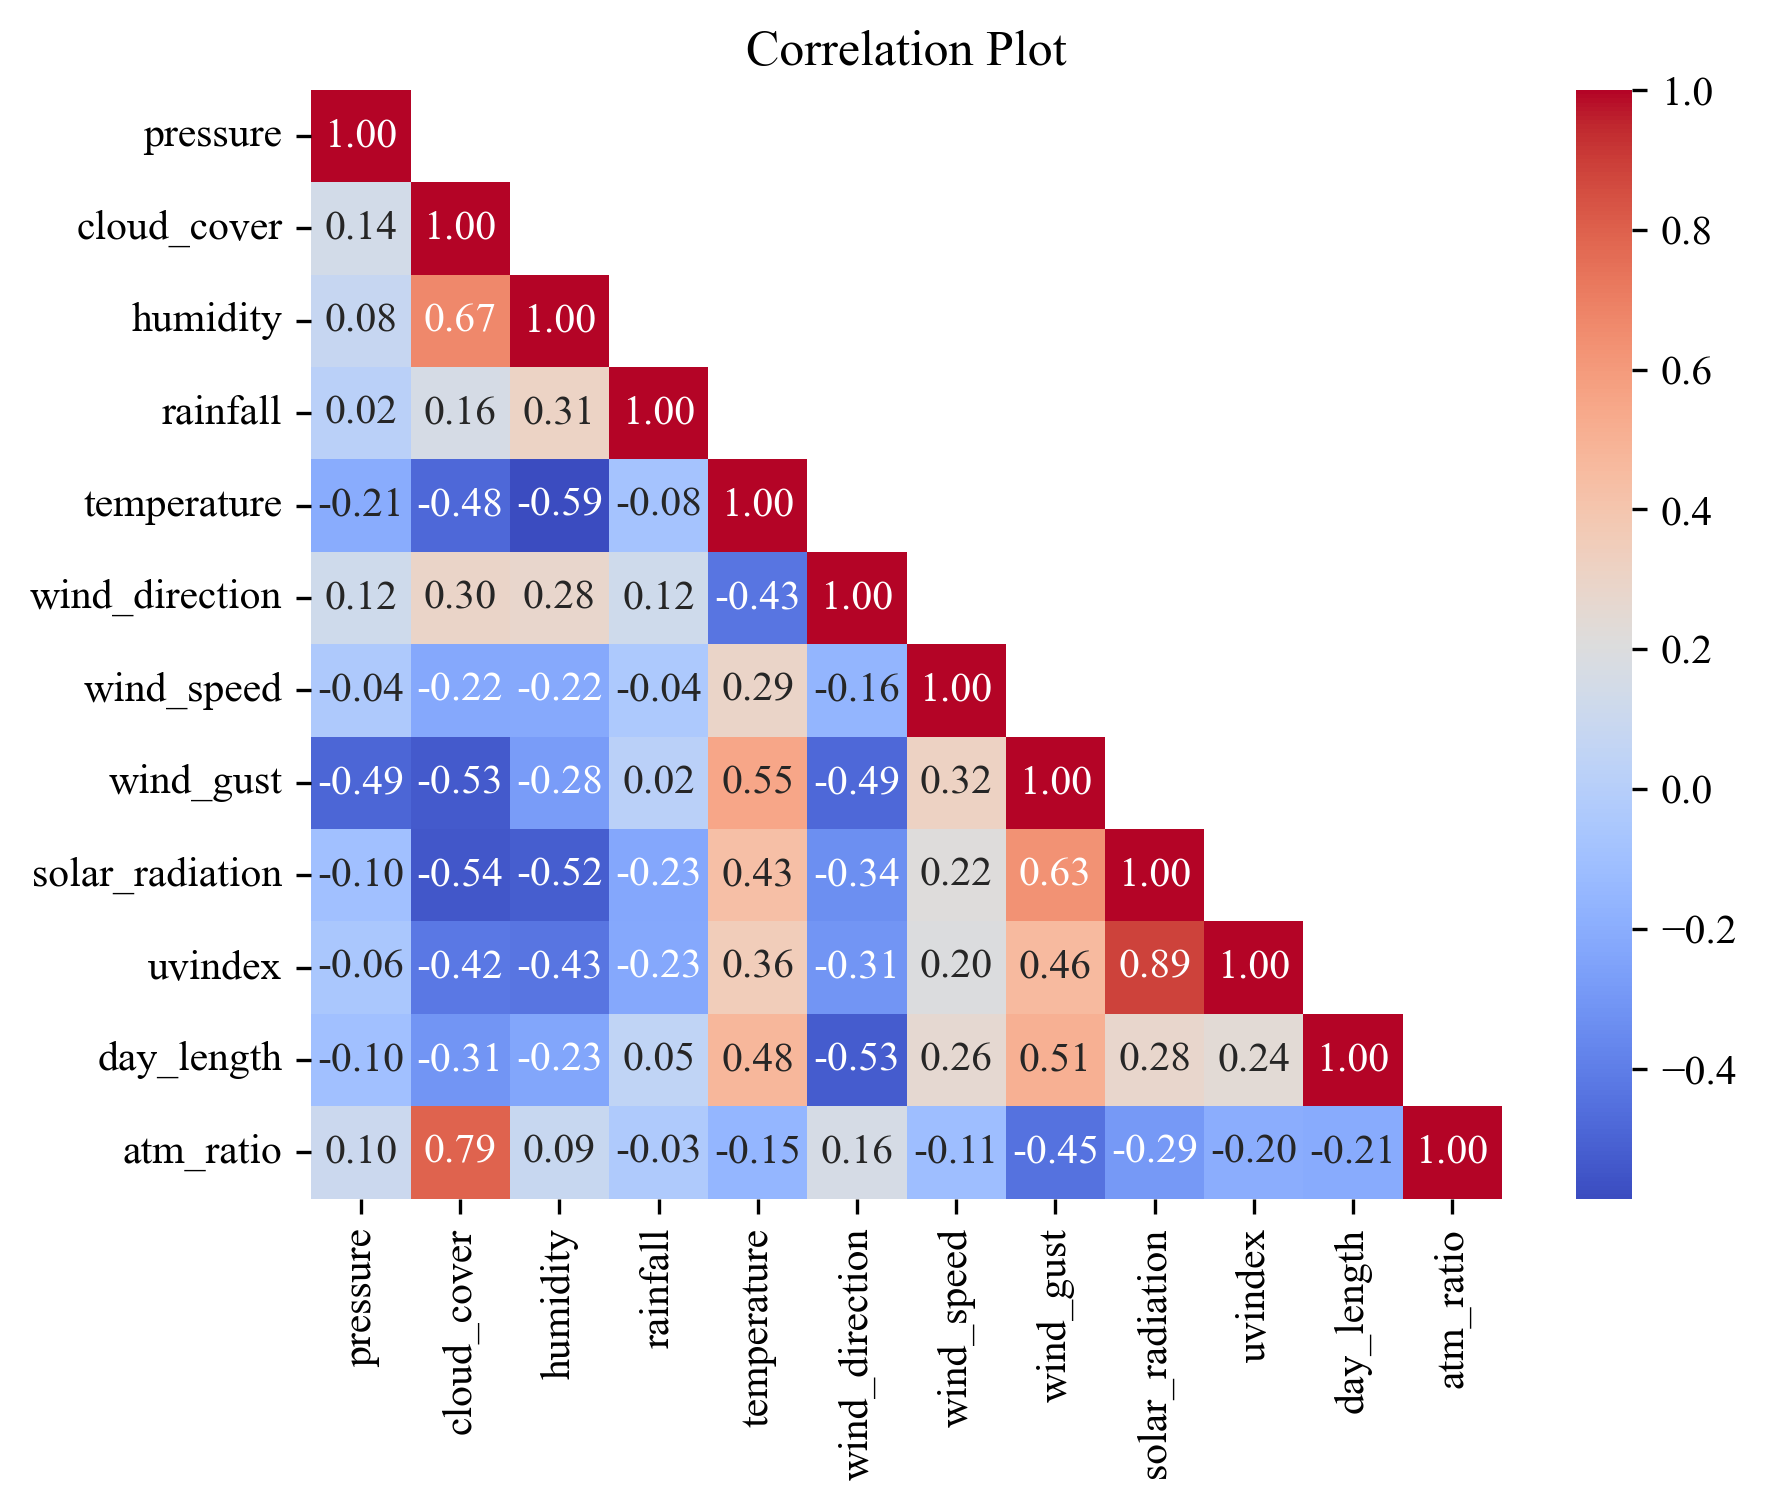

In [32]:
#create a correlation plot
corr = nbi_w_data.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
mask[np.diag_indices_from(mask)] = False
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',mask=mask)
plt.title('Correlation Plot')
plt.show()

## Data Cleaning

**Missing Values**

In [33]:
#checking for missing values
for col in nbi_w_data.columns:
    n_mv = sum(nbi_w_data[col].isna())
    print(f'{col}:{n_mv}')

pressure:2801
cloud_cover:0
humidity:0
rainfall:0
temperature:0
wind_direction:0
wind_speed:0
wind_gust:3143
condition:0
solar_radiation:0
uvindex:0
sunrise:0
sunset:0
day_length:0
atm_ratio:0


**Imputation**

In [34]:
def perform_multiple_imputation(df, num_iterations=10):
    """
    Performs multiple imputation on a dataframe using the IterativeImputer class
    from scikit-learn and returns a new dataframe with the imputed values.
    
    Args:
        df (pandas.DataFrame): The input dataframe to be imputed.
        num_iterations (int): The number of iterations to run the imputer. Default
            value is 10.
            
    Returns:
        pandas.DataFrame: A new dataframe with the imputed values.
    """
    # Create an IterativeImputer object and fit it to the data
    imputer = IterativeImputer(max_iter=num_iterations)
    imputed_data = imputer.fit_transform(df)

    # Create a new dataframe with the imputed data
    imputed_df = pd.DataFrame(imputed_data, columns=df.columns)

    return imputed_df


# Perform multiple imputation
imputed_data = perform_multiple_imputation(nbi_w_data[['pressure','wind_gust']])

#update the original dataframe
nbi_w_data[['pressure','wind_gust']] = imputed_data.values

C:\Users\noyug\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


**Removing outliers**

In [35]:
def remove_outliers(df, columns, factor=3):
    """
    Removes outliers from a pandas dataframe for the specified columns.

    Args:
        df (pandas.DataFrame): The input dataframe.
        columns (list): A list of column names to check for outliers.
        factor (float): A multiplier for the interquartile range used to
            determine outliers. Default is 3.

    Returns:
        pandas.DataFrame: The cleaned dataframe.
    """
    cleaned_df = df.copy()

    for col in columns:
        # Calculate the interquartile range
        q1 = cleaned_df[col].quantile(0.25)
        q3 = cleaned_df[col].quantile(0.75)
        iqr = q3 - q1

        # Define the lower and upper bounds
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr

        # Remove outliers
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

    return cleaned_df


In [36]:
# Specify columns to check for outliers
columns = ['wind_direction','wind_speed','sunrise']

# Remove outliers and get the cleaned dataframe
cleaned_df = remove_outliers(nbi_w_data, columns)

# Print the number of rows removed due to outliers
print(f"Removed {len(nbi_w_data) - len(cleaned_df)} rows due to outliers.")

# Print the first few rows of the cleaned dataframe
cleaned_df.dropna().info()

Removed 50 rows due to outliers.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3602 entries, 2013-01-01 to 2022-12-31
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pressure         3602 non-null   float64       
 1   cloud_cover      3602 non-null   float64       
 2   humidity         3602 non-null   float64       
 3   rainfall         3602 non-null   int32         
 4   temperature      3602 non-null   int32         
 5   wind_direction   3602 non-null   float64       
 6   wind_speed       3602 non-null   int32         
 7   wind_gust        3602 non-null   float64       
 8   condition        3602 non-null   object        
 9   solar_radiation  3602 non-null   float64       
 10  uvindex          3602 non-null   int64         
 11  sunrise          3602 non-null   datetime64[ns]
 12  sunset           3602 non-null   datetime64[ns]
 13  day_length       3602 non-null   float64  

## Modeling

**Seperate inputs from output**

In [37]:
X = cleaned_df.drop(columns=['solar_radiation','sunrise','sunset','condition'],axis=1)
y = cleaned_df['solar_radiation']

**Split the data into training and testing sets**

In [38]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Define the pipeline**

In [39]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('reg', LinearRegression())
])

**Fit the pipeline to the training data**

In [40]:
model = pipeline.fit(X_train, y_train)

**Perform prediction**

In [41]:
y_pred = model.predict(X_test)

**Save the results**

In [42]:
results = X_test[:].copy()
results['solar_radiation'] = y_pred
results.to_csv('results.csv')
results.head()

,pressure,cloud_cover,humidity,rainfall,temperature,wind_direction,wind_speed,wind_gust,uvindex,day_length,atm_ratio,solar_radiation
date,,,,,,,,,,,,
2021-06-02,1.021800,60.4,66.3,0,18,123.3,6,7.928068,9,723.000000,0.911011,260.856309
2015-10-14,1.019296,77.7,59.7,0,21,85.5,5,9.412260,10,728.200000,1.301508,301.705047
2018-08-30,1.019296,87.9,66.4,0,17,100.7,4,9.412260,9,725.133333,1.323795,250.828442
2021-09-23,1.021200,81.8,65.7,0,19,101.5,6,8.283637,10,726.700000,1.245053,293.289727
2017-01-14,1.019296,40.9,48.6,0,21,46.0,6,9.412260,10,731.133333,0.841564,315.644670


In [43]:
# access intercept and coefficient
#intercept = pipeline.named_steps['reg'].intercept_
#coefficient = pipeline.named_steps['reg'].coef_

In [44]:
# get feature names
#feature_names = pipeline.named_steps['poly'].get_feature_names()

# create dictionary of coefficients
#coefficient_dict = {name: value for name, value in zip(feature_names, coefficient)}
#pprint.pprint(coefficient_dict)

**Validate the model**

In [45]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'r\u00B2\t: {r2:.2f}\nRMSE\t: {rmse:.0f}')

r²	: 0.86
RMSE	: 20


**Plot predicted vs actual values**

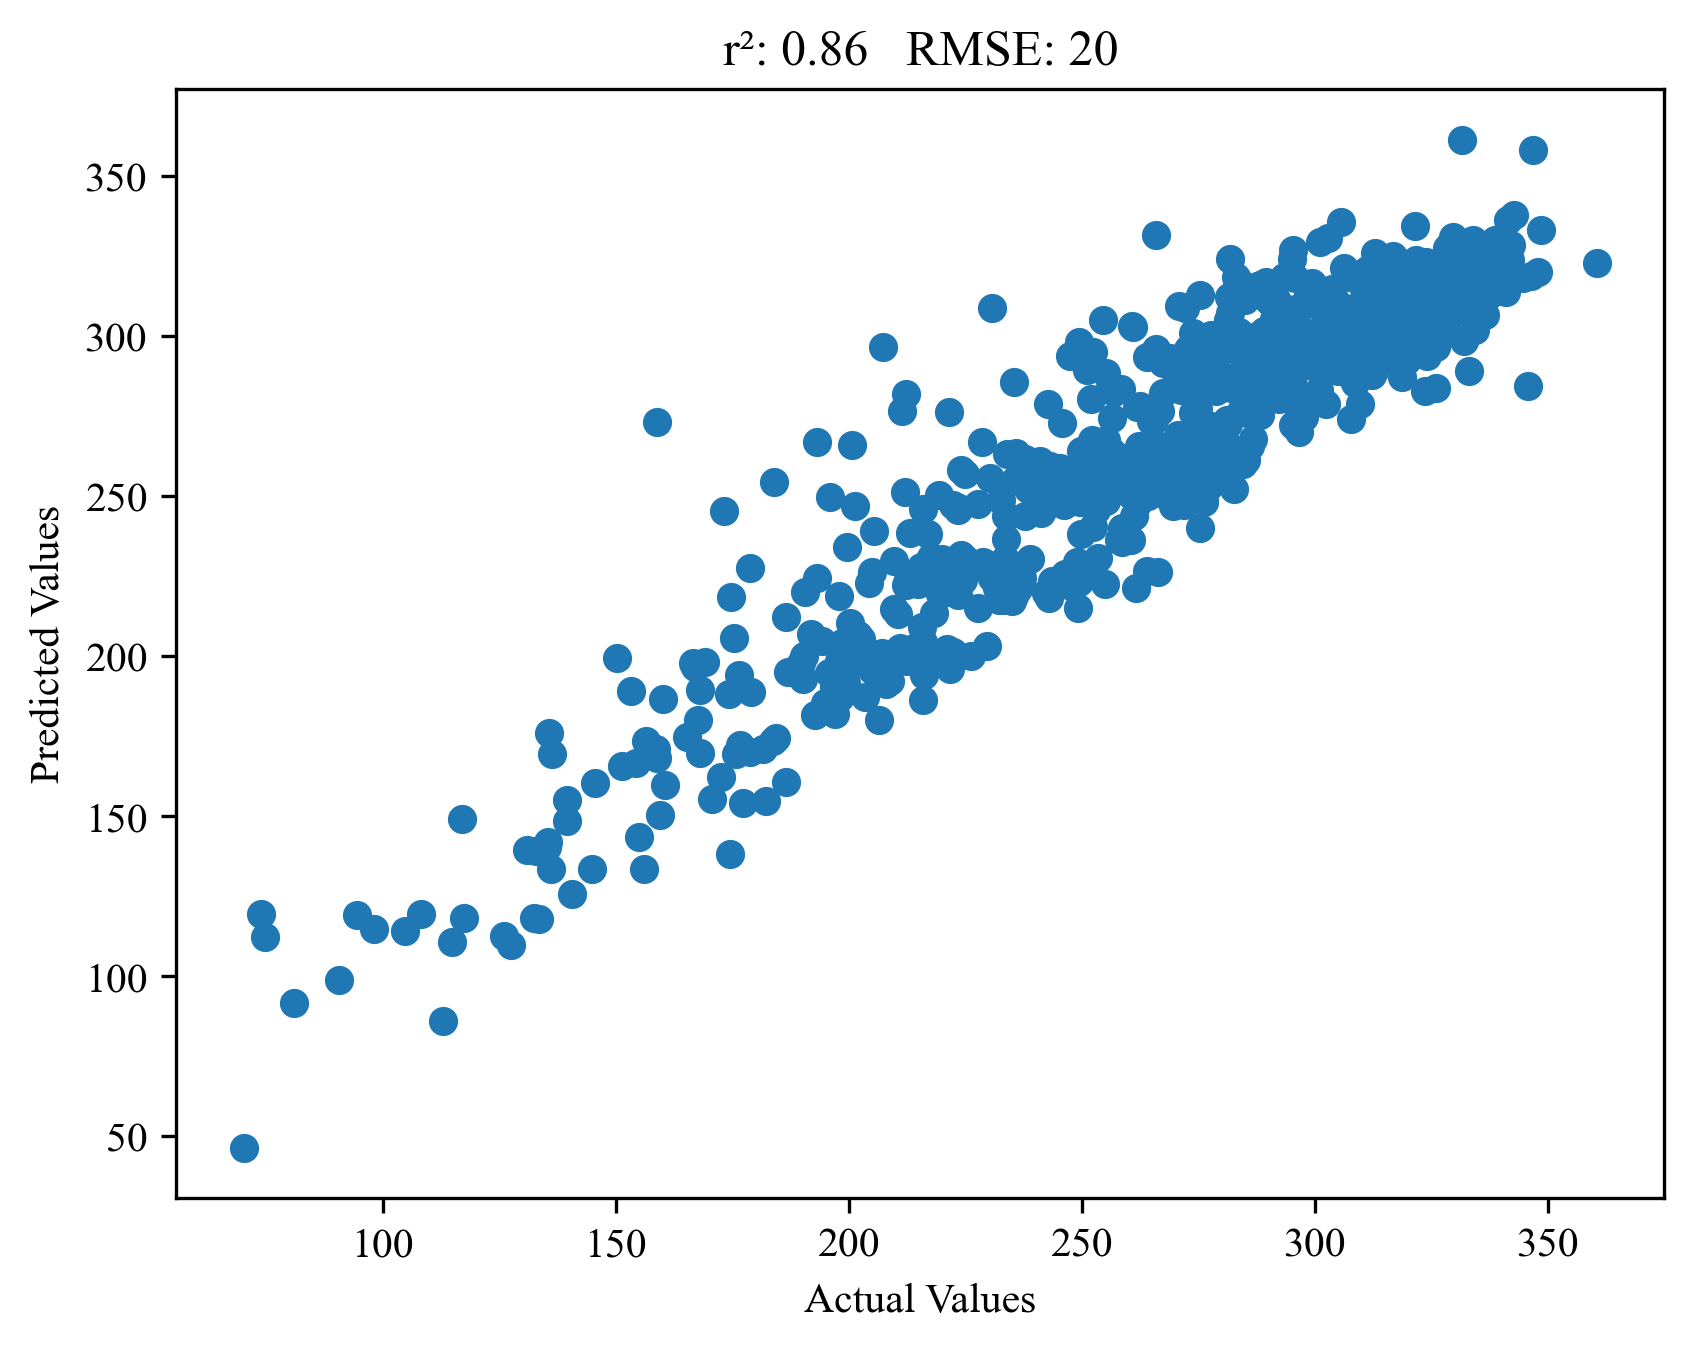

In [46]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'r\u00B2: {r2:.2f}   RMSE: {rmse:.0f}')
plt.show()

**Modularized**

In [47]:
def polynomial_regression(X, y, degree=2, test_size=0.2, random_state=42):
    """
    Perform polynomial regression to predict solar radiation using weather data.

    Parameters:
    X (pandas DataFrame): Input features.
    y (pandas Series): Target variable.
    degree (int): Degree of the polynomial features. Default is 2.
    test_size (float): Proportion of the data to use for testing. Default is 0.2.
    random_state (int): Random state for splitting the data. Default is 42.

    Returns:
    results (dict): Dictionary of results including R-squared score, root mean squared error, and plot of predicted vs. actual values.
    """
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define the pipeline
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree)),
        ('reg', LinearRegression())
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Predict the solar radiation for the test data
    y_pred = pipeline.predict(X_test)

    # Calculate the R-squared score and root mean squared error
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Plot predicted vs. actual values
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'R\u00B2: {r2:.2f}  DEGREE: {degree}  RMSE: {rmse:.0f}')
    plt.savefig('reg_plot.png')
    plt.show()

    # Store results in a dictionary
    results = {
        'degree': degree,
        'R-squared': r2,
        'RMSE': rmse
    }

    return results

**Get the results**

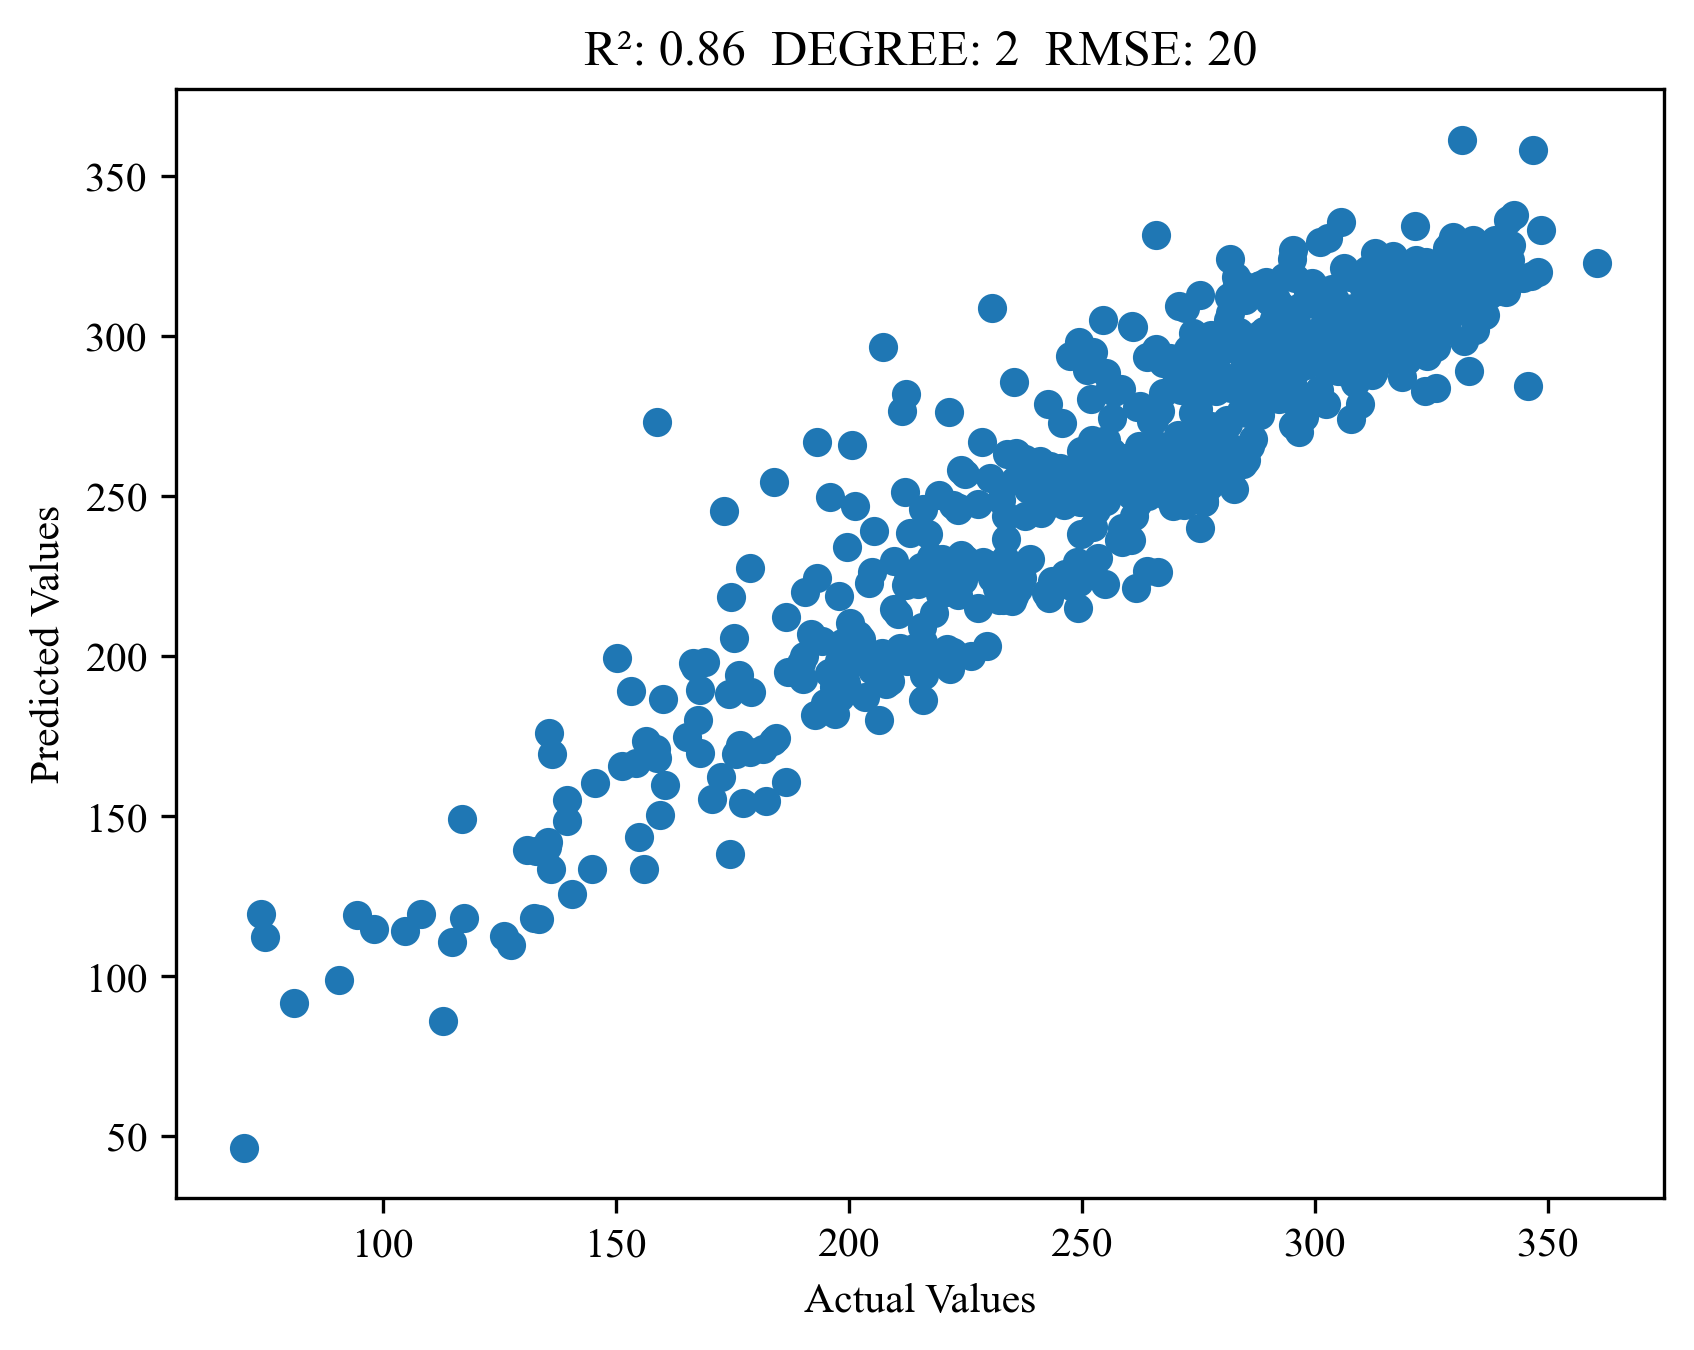

Degree of polynomial features: 2
R-squared score: 0.8604196109631436
Root mean squared error: 20.19691673991653


In [48]:
# Separate the input features (X) and target variable (y)
X = cleaned_df.drop(columns=['solar_radiation','sunrise','sunset','condition'])
y = cleaned_df['solar_radiation']

# Test the function
results = polynomial_regression(X, y)

# Print the results
print('Degree of polynomial features:', results['degree'])
print('R-squared score:', results['R-squared'])
print('Root mean squared error:', results['RMSE'])


The R squared is 0.86 this shows that the model fits the data very well. The predicted values are also close to the actual values and there's is no large disrepancy.